In [1]:
# !pip install git+https://github.com/joaopfonseca/ml-research

In [2]:
import sys

sys.path.append("../")

In [3]:
from itertools import product
from copy import deepcopy
from rich.progress import track

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LogisticRegression

from mlresearch.utils import set_matplotlib_style, parallel_loop
from algorec.recourse import NFeatureRecourse
from algorec.populations import BasePopulation
from algorec.environments import BankLoanApplication2, BankLoanApplication3, WillingnessEnvironment

In [4]:
set_matplotlib_style(8, **{"lines.markersize": 1})

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Generate data and fit regression
continuous = [f"f_{i}" for i in range(N_CONTINUOUS)]
categorical = [f"cat_{i}" for i in range(N_CAT)]
rng = np.random.default_rng(RNG_SEED)
df = pd.DataFrame(
    rng.random((N_AGENTS, N_CONTINUOUS)),
    columns=[f"f_{i}" for i in range(N_CONTINUOUS)],
)

for i in range(N_CAT):
    df[f"cat_{i}"] = rng.integers(0, 2, N_AGENTS)

y = rng.integers(0, 2, N_AGENTS)
lr = LogisticRegression().fit(df, y)

In [5]:
population = BasePopulation(df, categorical=categorical)

# Remove upper and lower bounds
population.action_set_.ub = [1, 1]
population.action_set_.lb = [0, 0]

recourse = NFeatureRecourse(lr, n_features=2)

# Function Definitions

In [6]:
def agent_scores_panel(results, adaptation_list, new_agents_list):
    fig, axes = plt.subplots(
        len(adaptation_list),
        len(new_agents_list),
        figsize=(10, 10),
        layout="constrained",
        sharey=True,
        sharex=True,
    )

    for params, env in track(results):
        i = adaptation_list.index(params["adaptation"])
        j = new_agents_list.index(params["new_agents"])

        ax = env.plot.agent_scores(title=False, legend=False, ax=axes[i, j])
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticks(range(0, 51, 10))
        ax.set_xlim(-1, 51)

    for i in range(len(adaptation_list)):
        axes[i, 0].set_ylabel(f"{adaptation_list[i]}")

    for j in range(len(new_agents_list)):
        axes[-1, j].set_xlabel(f"{new_agents_list[j]}")

    fig.supxlabel("\# New Agents")
    fig.supylabel("Adaptation")

    return fig, axes

In [7]:
# TODO: spline in red, actual data in light blue
# Increase spline's smoothness


def success_rate_panels(results, adaptation_list, new_agents_list):
    fig, axes = plt.subplots(
        len(adaptation_list),
        len(new_agents_list),
        figsize=(10, 10),
        layout="constrained",
        sharey=True,
        sharex=True,
    )

    for params, env in track(results):
        i = adaptation_list.index(params["adaptation"])
        j = new_agents_list.index(params["new_agents"])
        sr = env.success_rate(1, env.step_ + 1)
        sr_smooth = gaussian_filter1d(
            np.where(np.isnan(sr), sr[~np.isnan(sr)].mean(), sr), sigma=5
        )

        ax = axes[i, j]
        ax.plot(range(1, env.step_ + 1), sr, alpha=0.25)
        ax.plot(range(1, env.step_ + 1), sr_smooth, c="#d75c5c")
        ax.set_xticks(range(0, 51, 10))
        ax.set_xlim(-1, 51)

    for i in range(len(adaptation_list)):
        axes[i, 0].set_ylabel(f"{adaptation_list[i]}")

    for j in range(len(new_agents_list)):
        axes[-1, j].set_xlabel(f"{new_agents_list[j]}")

    fig.suptitle("Success rate")
    fig.supxlabel("\# New Agents")
    fig.supylabel("Adaptation")

    return fig, axes

# Bank Loan application - Gaussian adaptation

In [8]:
# Meta-simulation variables
N_LOANS_BLA3 = [10]  # number of loans is fixed
ADAPTATION_BLA3 = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_BLA3 = [8, 9, 10, 11, 12]
N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [9]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = BankLoanApplication3(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except ValueError:
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_bla3 = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

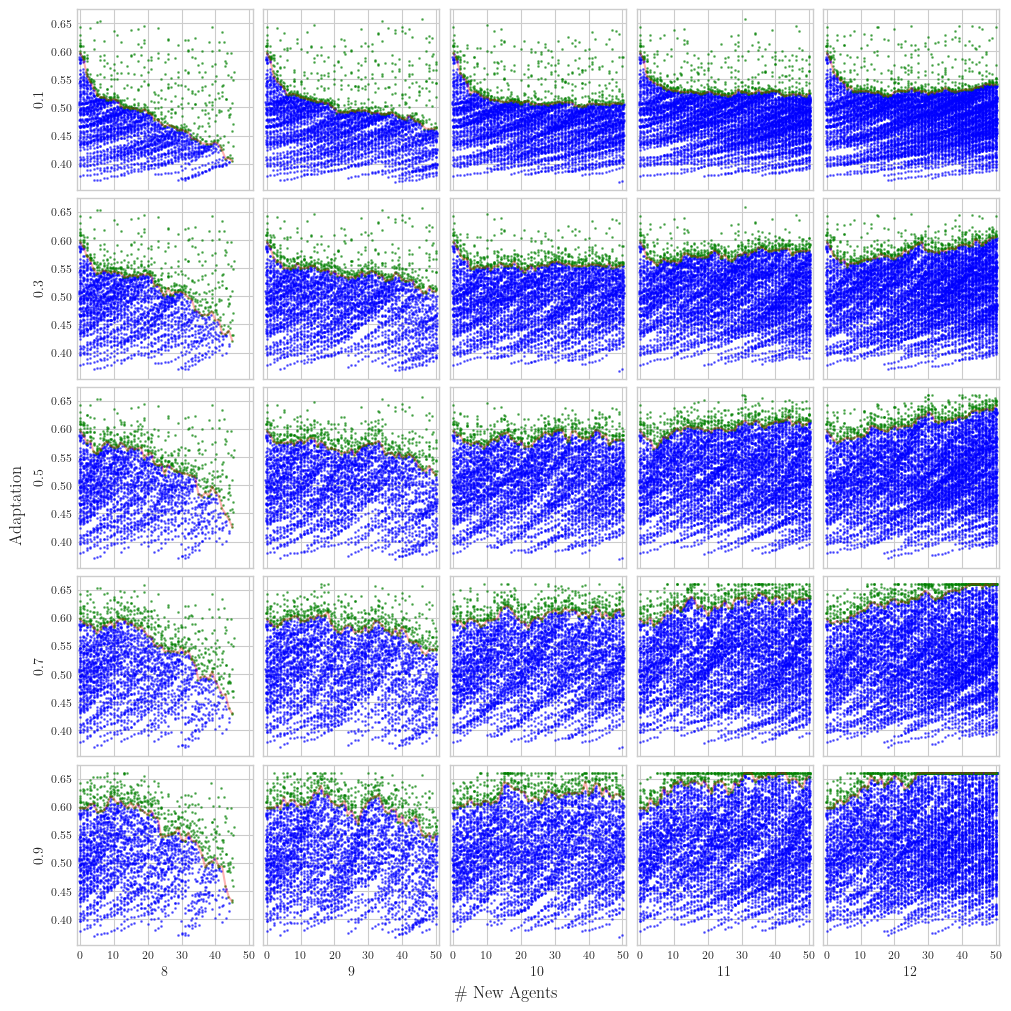

In [10]:
agent_scores_panel(results_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
plt.show()

Output()

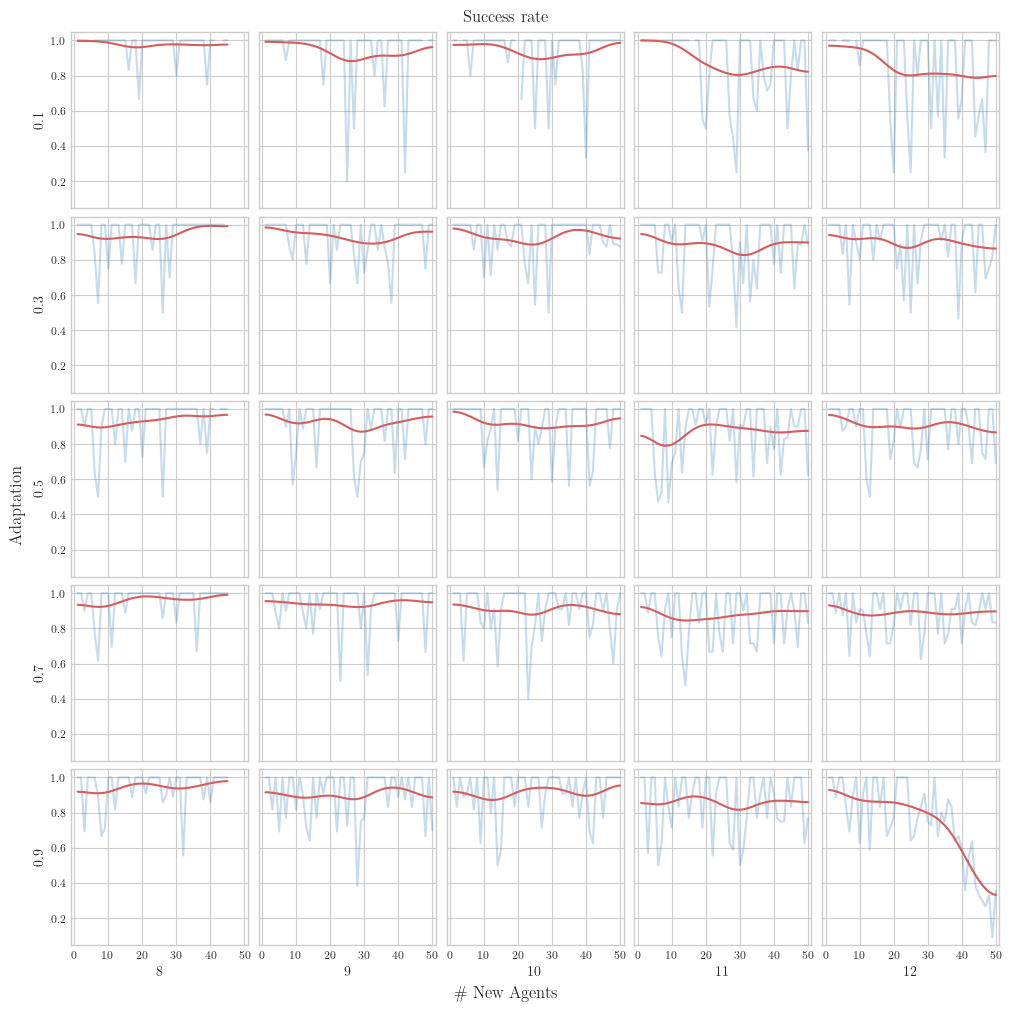

In [11]:
success_rate_panels(results_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
plt.show()

# Bank Loan application - Binary adaptation

In [12]:
# Meta-simulation variables
N_LOANS_BLA2 = [10]  # number of loans is fixed
ADAPTATION_BLA2 = [8, 9, 10, 11, 12]
NEW_AGENTS_BLA2 = [8, 9, 10, 11, 12]
N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2

([10], [8, 9, 10, 11, 12], [8, 9, 10, 11, 12])

In [13]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = BankLoanApplication2(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except (ValueError, KeyError):
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_bla2 = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

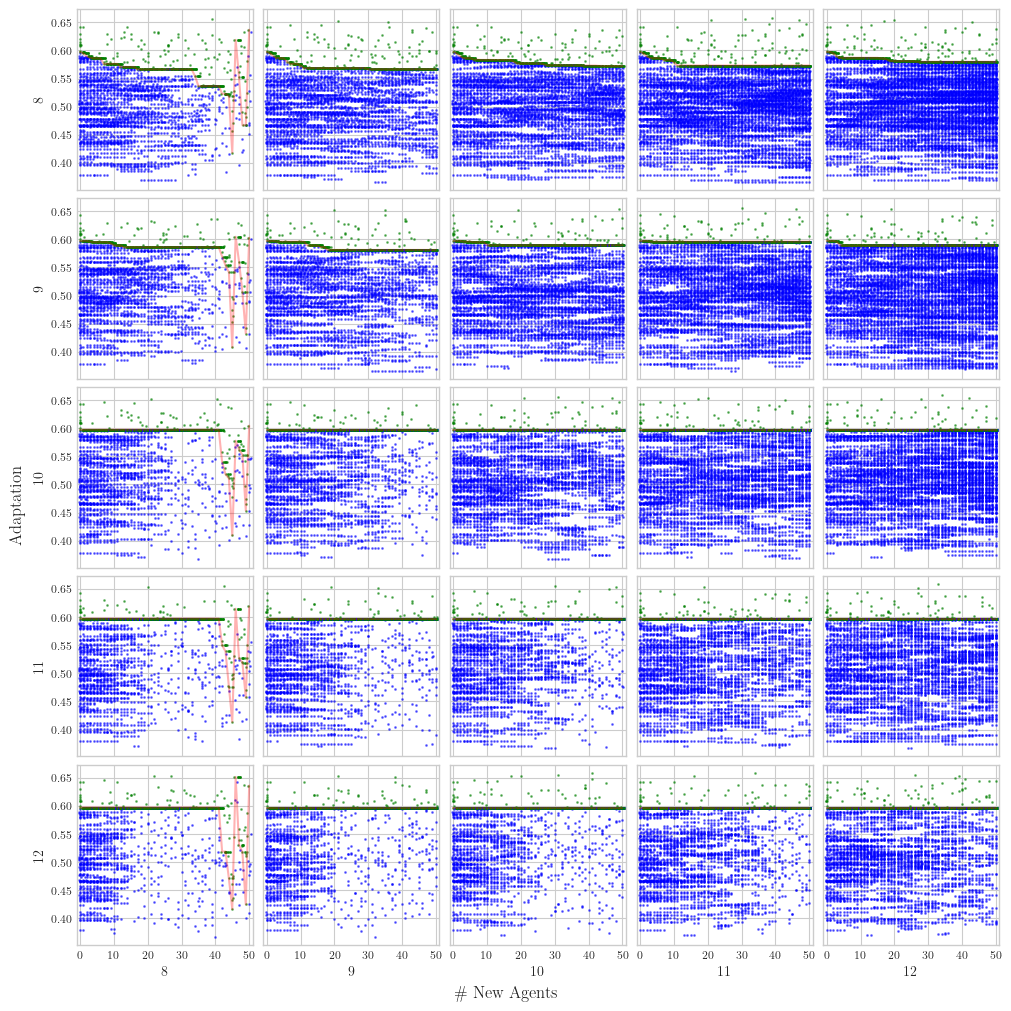

In [14]:
agent_scores_panel(results_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
plt.show()

Output()

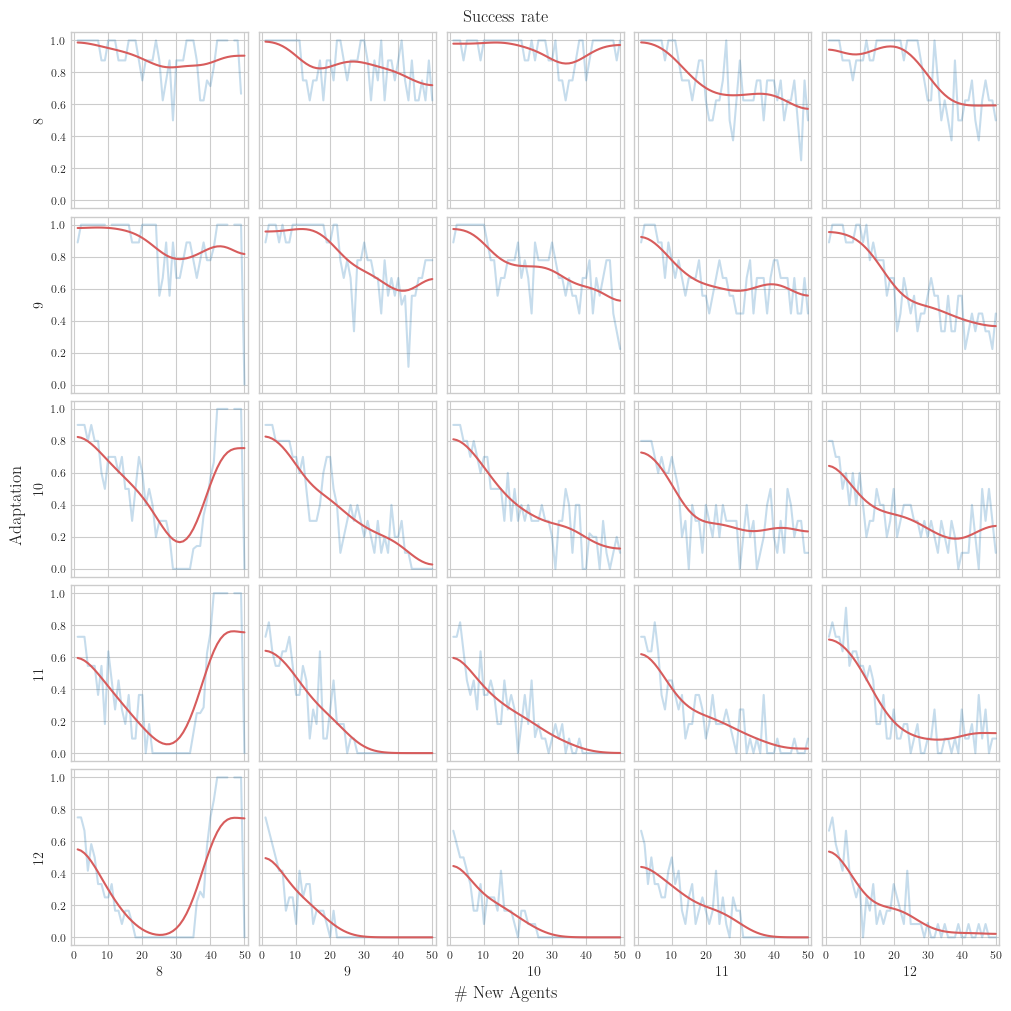

In [15]:
success_rate_panels(results_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
plt.show()

# Willingness Environment

In [8]:
# Meta-simulation variables
N_LOANS_WILL = [10]  # number of loans is fixed
ADAPTATION_WILL = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_WILL = [8, 9, 10, 11, 12]
N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [9]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = WillingnessEnvironment(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except ValueError:
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_will = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

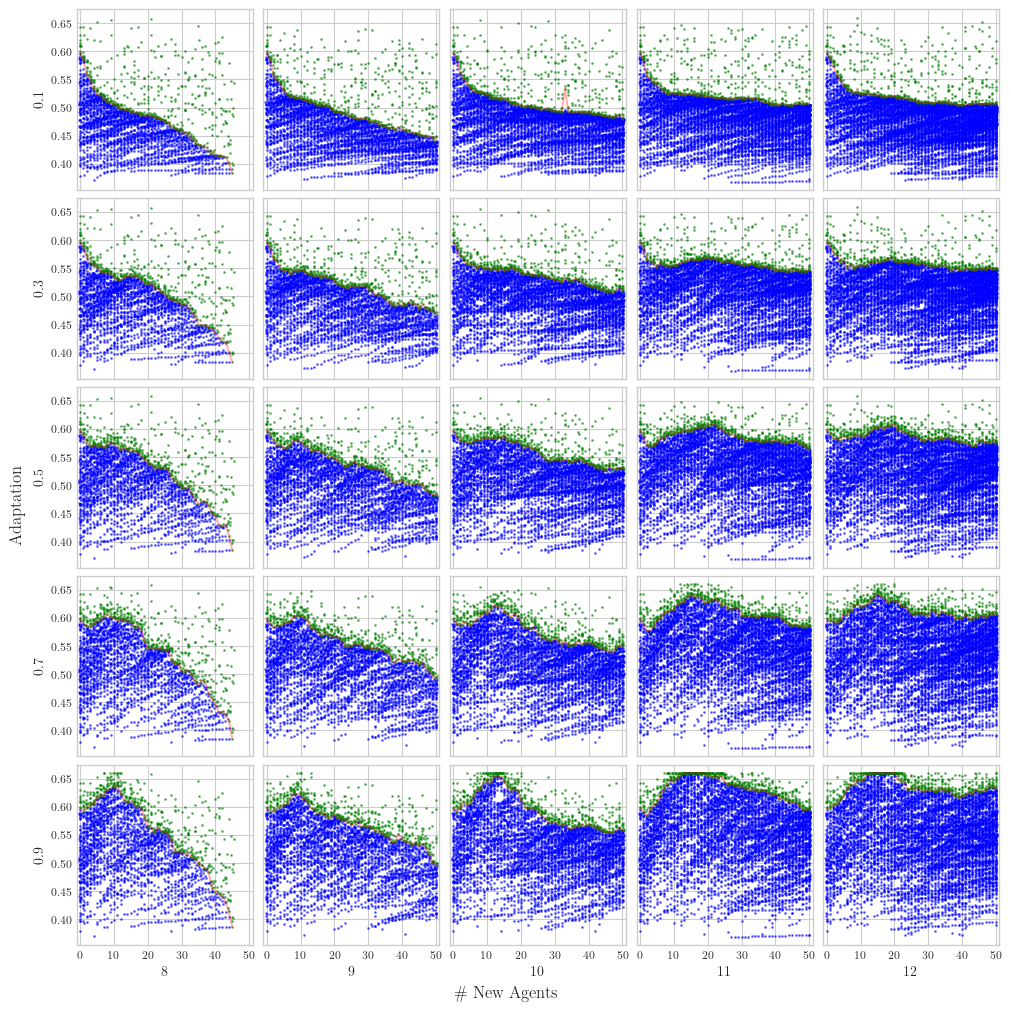

In [10]:
agent_scores_panel(results_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
plt.show()

Output()

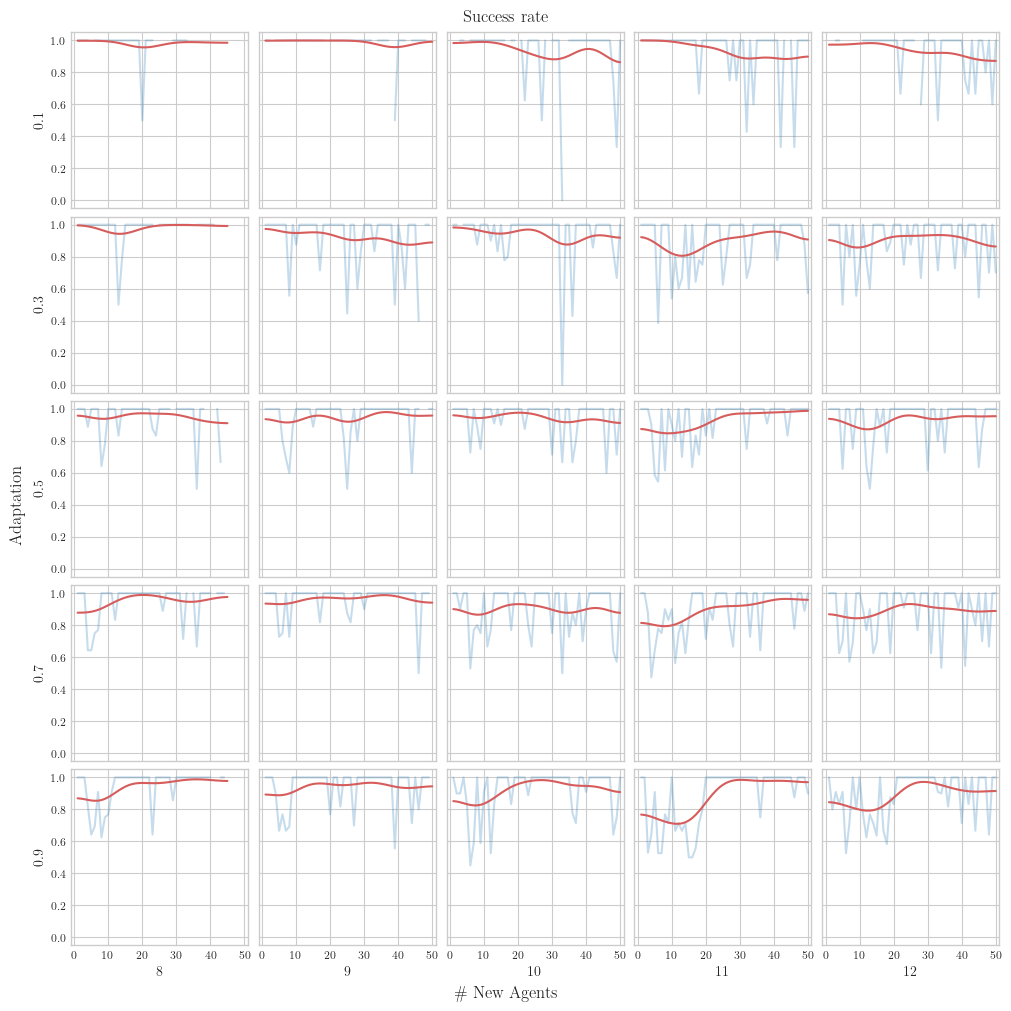

In [11]:
success_rate_panels(results_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
plt.show()